# Generating 100,000 FSPS Spectra with Diverse SFHs

Goal is to get a more thoroughly sampled manifold, with more diverse star formation histories spanning a wider range of mean ages...
Updated 2017-02-07 to use zcontinuous=1 (vs. integer values for metallicity)
Updated 2017-08-09 to generate another 100,000 spectra with same distribution of parameters as before in attempt to better populate manifold of spectra for ML application.

In [1]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import fsps
from astroML.plotting import setup_text_plots
import h5py
import time
date = time.strftime("%y-%m-%d")

np.set_printoptions(suppress=True)
setup_text_plots(fontsize=24)
mpl.rc('xtick', labelsize=18)
mpl.rc('ytick', labelsize=18)
mpl.rc('font', size=24, family='serif', style='normal', variant='normal', stretch='normal', weight='bold')
mpl.rc('legend', labelspacing=0.1, handlelength=2, fontsize=13)
mpl.rc('axes', labelweight='black')

#### Allow sf_begin, fburst, tburst, tau, z, dust2 to vary -- age will be weighted average of ages of different components. sf_begin, fburst, tau distributed logarithmically; z, bust2, tburst uniform

In [2]:
# get 100,000 samples
size=100000

#sf_begin = np.random.uniform(low=0.0, high=12.2, size=size)
logsf_begins = np.random.uniform(low=np.log10(0.1), high=np.log10(12.2), size=size)
sf_begins = 10**logsf_begins
As = 13.7 - sf_begins

logtbursts = np.array([])
for ii in range(size):
    logtbursts = np.append(logtbursts, np.random.uniform(low=np.log10(sf_begins[ii]), high=np.log10(13.6)))
tbursts = 10**logtbursts

logfbursts = np.random.uniform(low=np.log10(0.01), high=np.log10(0.5), size=size)
fbursts = 10**logfbursts

#taus = np.random.uniform(low=1.0, high=100, size=size) # this resulted in WAY too few old galaxies...
logtaus = np.random.uniform(low=-0.5, high=1.5, size=size)
taus = 10**logtaus
tau_ages = As - taus * ( (1. - (As/taus + 1.) * np.exp(-As/taus)) / (1. - np.exp(-As/taus)) ) # mean ages given taus

total_ages = (1-fbursts) * tau_ages + fbursts * (13.7 - tbursts)

dusts = np.random.uniform(low=0.0, high=1.0, size=size)

zs = np.random.uniform(low=-1.5, high=0.2, size=size) #not an ideal distribution; will get a lot of low metallicities...

#sigmas = np.random.uniform(low=0.0, high=300.0, size=size)

In [3]:
# do metallicity separately b/c need to choose integer for each model -- logz_values copied from FSPS manual
#logz_values = np.array([-1.98, -1.80, -1.68, -1.58, -1.50, -1.38, -1.28, -1.20, -1.07, -0.98, -0.89, -0.79, \
#                        -0.69, -0.59, -0.49, -0.39, -0.30, -0.20, -0.10, 0.0, 0.10, 0.20])

#znums = np.random.randint(low=1, high=23, size=size) #want values from 1-22; high is exclusive
#zinds = znums - 1 #b/c the znum starts at 1, not 0... ugh
#zs = logz_values[zinds]

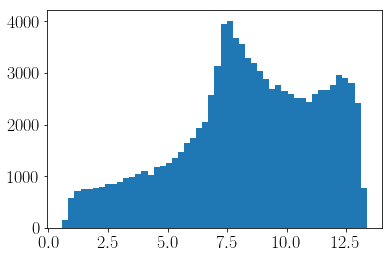

In [4]:
n, bins, patches = plt.hist(total_ages, bins=50)

In [5]:
np.max(sf_begins)

12.199514041348374

#### now build the model spectra

In [6]:
spectra = np.zeros((size, 4220)) #know there are 4220 steps in desired wavelength range
mags = np.zeros((size, 5)) # save mags in 5 SDSS filters
bands = fsps.find_filter('sdss') # u, g, i, r, z (NOTE SILLY ORDERING)
ii = 0

for sf_begin, tburst, fburst, tau, dust, z  in zip(sf_begins, tbursts, fbursts, taus, dusts, zs):
    sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=4, sigma_smooth=100., dust_type=2,
                                add_neb_emission=False, sf_start=sf_begin, tburst=tburst, fburst=fburst,
                                tau=tau, dust2=dust, zcontinuous=1, logzsol=z)
    wave, spec = sp.get_spectrum(tage=13.7, peraa=True)
    wh = (wave < 7400.) * (wave > 3600.)
    spectra[ii, :] = spec[wh]
    mags[ii, :] = sp.get_mags(bands=fsps.find_filter('sdss'), tage=13.7)
    ii += 1
    if ii%1000 == 0:
        percent = ii/1000.
        print "%d percent complete" % percent

1 percent complete
2 percent complete
3 percent complete
4 percent complete
5 percent complete
6 percent complete
7 percent complete
8 percent complete
9 percent complete
10 percent complete
11 percent complete
12 percent complete
13 percent complete
14 percent complete
15 percent complete
16 percent complete
17 percent complete
18 percent complete
19 percent complete
20 percent complete
21 percent complete
22 percent complete
23 percent complete
24 percent complete
25 percent complete
26 percent complete
27 percent complete
28 percent complete
29 percent complete
30 percent complete
31 percent complete
32 percent complete
33 percent complete
34 percent complete
35 percent complete
36 percent complete
37 percent complete
38 percent complete
39 percent complete
40 percent complete
41 percent complete
42 percent complete
43 percent complete
44 percent complete
45 percent complete
46 percent complete
47 percent complete
48 percent complete
49 percent complete
50 percent complete
51 percen

#### normalize the spectra

In [7]:
norms = spectra.shape[1] / np.sum(spectra, axis=1)
spectra_norm = spectra * norms[:,np.newaxis]

MemoryError: 

In [ ]:
# quick sanity check
plt.figure()
plt.plot(wave[wh], spectra_norm[100])
plt.plot(wave[wh], spectra_norm[1009])
plt.plot(wave[wh], spectra_norm[6095])
plt.plot(wave[wh], spectra_norm[9998])
plt.plot(wave[wh], spectra_norm[50628])
plt.plot(wave[wh], spectra_norm[82534])

#### save spectra and parameters to HDF5 file

In [ ]:
f = h5py.File('../data/1e5_spectra_diverseSFH_{}.hdf5'.format(date),'w')
f.create_dataset('spectra', data=spectra_norm)
f.create_dataset('wave', data=wave[wh])
f.create_dataset('sdss_mags', data=mags)
f.create_dataset('sf_begins', data=sf_begins)
f.create_dataset('tbursts', data=tbursts)
f.create_dataset('fbursts', data=fbursts)
f.create_dataset('taus', data=taus)
f.create_dataset('mean_ages', data=total_ages)
f.create_dataset('zs', data=zs)
f.create_dataset('dusts', data=dusts)

In [ ]:
f.keys()

In [ ]:
f['spectra'].shape

In [ ]:
f.close()